## SIMULATION OF SIR INFECTIOUS DISEASE MODEL FOR COVID-19

#### Author: Yiran Jing

### Content:
1. China Total
2. Ex-Hubei
3. Hubei
4. Ex-China

In [4]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import pandas as pd
import pandas
from math import *
import datetime
import matplotlib.dates as mdates
from Dynamic_SIR_model import *
from helper_fun_epi_model import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

In [5]:
## Some assumptions
China_population = 1400000000
Hubei_population = 58500000

### Load data and clean data

In [6]:
## Load data 
df = pd.read_csv("../data/DXYArea.csv")

"""
Data Cleaning 
"""
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] > datetime.datetime(2019, 12, 7)]  # first day is 2019-12-08
df = df[df['date'] != df['date'].max()] # remove todays' records (since it can be incompleted)

In [7]:
## Dataset preperation
df['R'] = df['cured'] + df['dead']
SIR_data = df[['date', 'Days', 'countryCode','province', 'city', 'net_confirmed','R', 
              ]].rename(columns={"net_confirmed": "I"})
#SIR_data.tail(3)

In [8]:
# China total

# Use data before 2020-02-14 for train model
China_df = SIR_data[SIR_data['date'] < datetime.datetime(2020, 2, 14)] 
China_total = get_China_total(China_df)
China_total.tail(2)

,date,Days,countryCode,province,city,I,R
6436,2020-02-12,66,CN,NaN,NaN,51933,6906
6781,2020-02-13,67,CN,NaN,NaN,55823,8109


### Estimate China Total

In [9]:
Dynamic_SEIR1 = Train_Dynamic_SIR(epoch = 10000, data = China_total, 
                 population = 1400000000, rateIR=1/14, c = 1, b = -10, alpha = 0.08)

In [10]:
estimation_df = Dynamic_SEIR1.train() 
est_beta = Dynamic_SEIR1.rateSI
est_alpha = Dynamic_SEIR1.alpha
est_b = Dynamic_SEIR1.b
est_c = Dynamic_SEIR1.c
population = Dynamic_SEIR1.numIndividuals

The loss in is 22087.04774553615
The MAPE in the whole period is 0.092139376536814


In [11]:
estimation_df.tail(2)

,Time,Estimated_Susceptible,Estimated_Infected,Estimated_Resistant
66,66.0,1.399938e+09,51559.624790,10615.500000
67,67.0,1.399933e+09,55287.252427,12096.357143


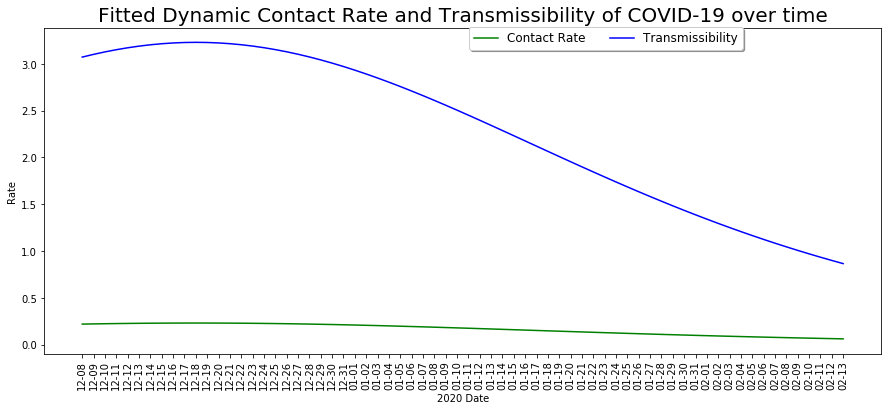

In [12]:
Dynamic_SEIR1.plot_fitted_beta_R0(China_total)

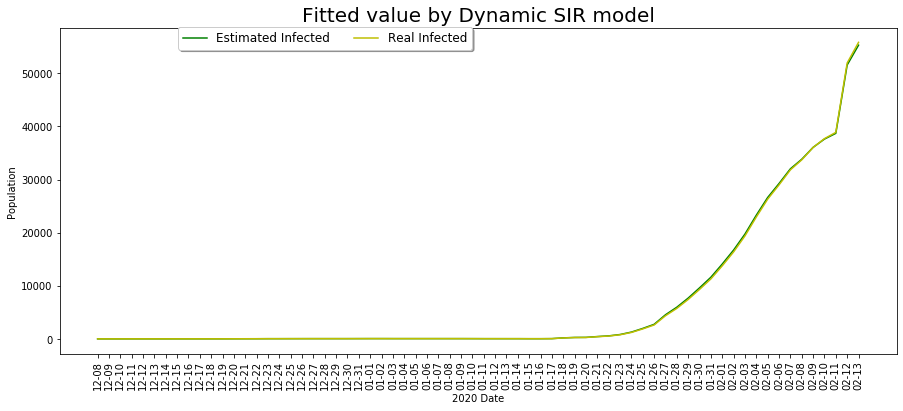

In [13]:
Dynamic_SEIR1.plot_fitted_result(China_total)

In [14]:
## use the last observation as the initial point in the new SEIR model

# I is the net confirmed cases (total confirmed case - heal - died)
I0 = list(China_total['I'])[-1]
R0 = list(China_total['R'])[-1]
S0 = population - I0 - R0

Maximum infected case:  55823


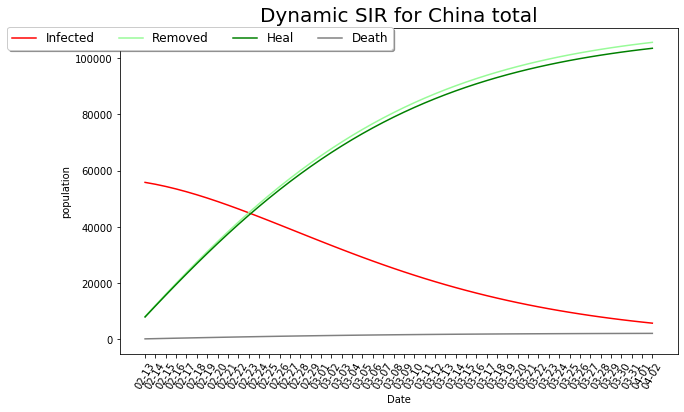

In [15]:
sir_new = dynamic_SIR(eons=50, Susceptible=S0, 
                    Infected=I0, Resistant=R0, rateIR=1/14, 
                    alpha = est_alpha, c = est_c, b = est_b, past_days = China_total['Days'].max())
result = sir_new.run(death_rate = 0.02) # assume death rate is 2%
sir_new.plot_noSuscep('Dynamic SIR for China total', 'population', 'Date', starting_point = China_total['date'].max())

The MAMPE is: 
0.07136447014345922


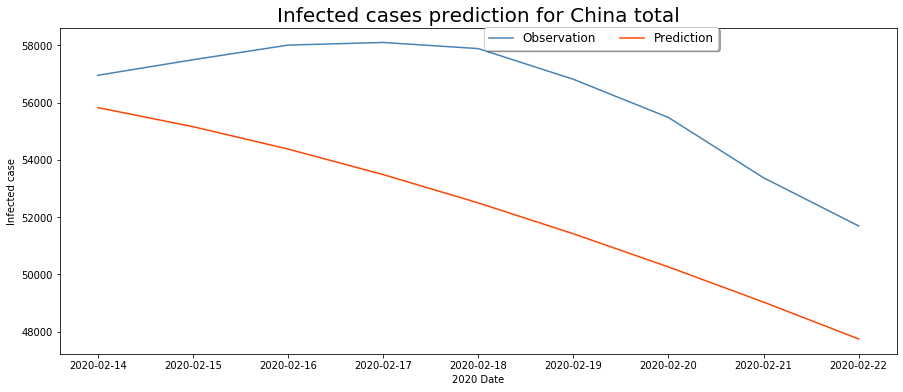

In [18]:
"""
Calculate MAPE test score using SEIR model result
"""
test = get_China_total(SIR_data[SIR_data['date'] >= datetime.datetime(2020, 2, 14)])
plot_test_data_with_MAPE(test, result)

### Estimate Ex-Hubei

The loss in is 50197.4503929758
The MAPE in the whole period is nan


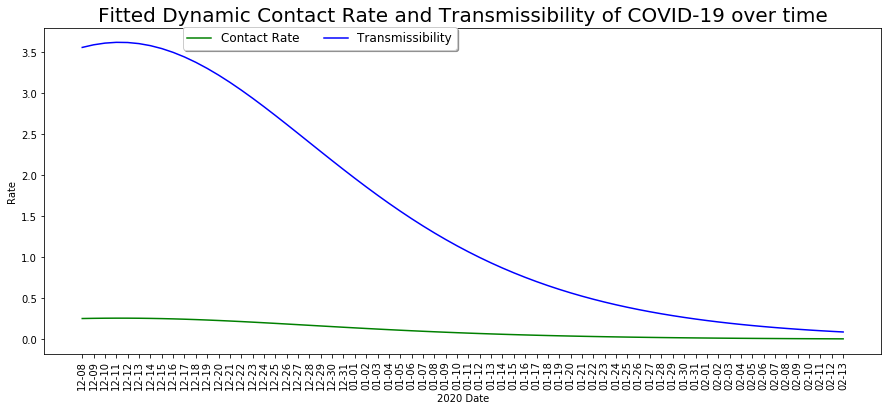

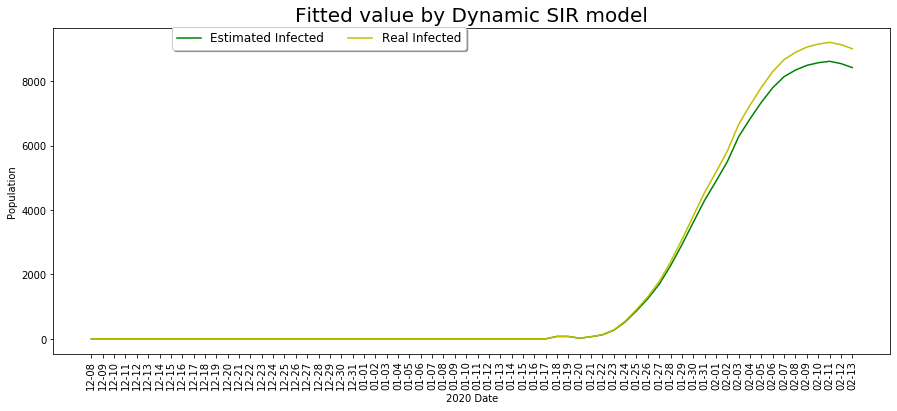

Maximum infected case:  11462


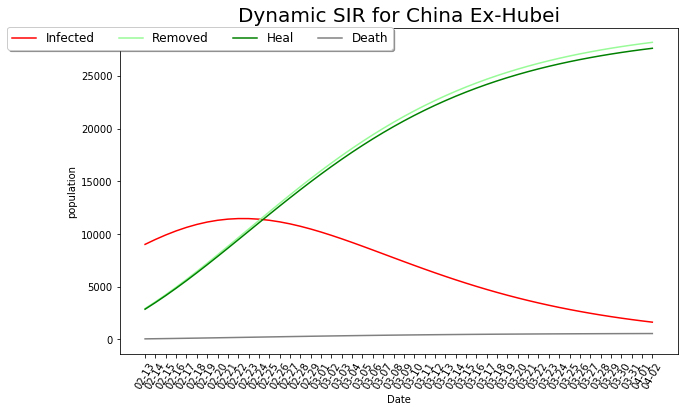

The MAMPE is: 
0.5206954945091026


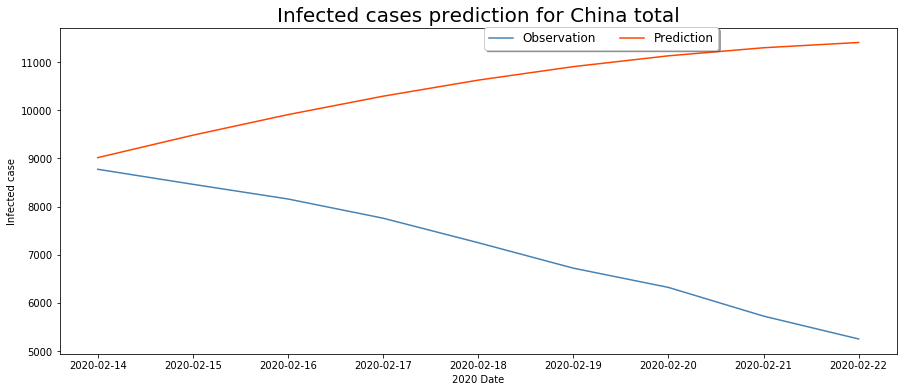

In [19]:
NotHubei = get_China_exclude_province(China_df, "Hubei Province")

Dynamic_SEIR2 = Train_Dynamic_SIR(epoch = 10000, data = NotHubei, 
                 population = China_population-Hubei_population, rateIR=1/14)

estimation_df = Dynamic_SEIR2.train() 
est_beta = Dynamic_SEIR2.rateSI
est_alpha = Dynamic_SEIR2.alpha
est_b = Dynamic_SEIR1.b
est_c = Dynamic_SEIR1.c
population = Dynamic_SEIR2.numIndividuals

# Draw fitted result
Dynamic_SEIR2.plot_fitted_beta_R0(NotHubei)
Dynamic_SEIR2.plot_fitted_result(NotHubei)

## use the last observation as the initial point in the new SEIR model
I0 = list(NotHubei['I'])[-1]
R0 = list(NotHubei['R'])[-1]
S0 = population - I0 - R0

sir_new2 = dynamic_SIR(eons=50, Susceptible=S0, 
                    Infected=I0, Resistant=R0, rateIR=1/14, 
                    alpha = est_alpha, c = est_c, b = est_b)

result2= sir_new2.run(death_rate = 0.02) # assume death rate is 2%
sir_new2.plot_noSuscep('Dynamic SIR for China Ex-Hubei', 'population', 'Date', starting_point = China_total['date'].max())

"""
Calculate MAPE test score using SEIR model result
"""
China_df_test = SIR_data[SIR_data['date'] >= datetime.datetime(2020, 2, 14)] 
test = get_China_exclude_province(China_df_test, "Hubei Province")

plot_test_data_with_MAPE(test, result2)

## Estimate Hubei 
Currently cannot be done, since the data source I use has no exposed number for Hubei province. 


The MAMPE is: 
0.1490067966037779


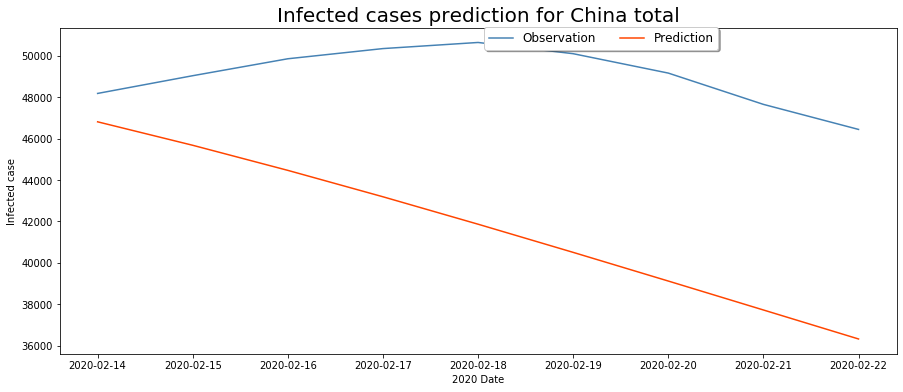

In [22]:
## estimted result 
result_Hubei = result - result2

China_df_test = SIR_data[SIR_data['date'] >= datetime.datetime(2020, 2, 14)] 
test = get_province_df(China_df_test, "Hubei Province")

plot_test_data_with_MAPE(test, result_Hubei)